In [394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


First, I import necessary libraries. Then, I load and process the data from my CSV files with predefined functions.

In [545]:
def length_mask(df,upper=2.7e5,lower=1.5e5):
    length_mask = (df['duration_ms']>upper)|(df['duration_ms']<lower)
    return length_mask

def split_table(music_table):
    labels = music_table.select_dtypes('object')
    labels['release date'] = pd.to_datetime(labels['release date'],errors='coerce')
    music_table[['key','mode','time_signature']] = music_table[['key','mode','time_signature']].astype('object')
    features = music_table.drop(labels,1)
    mask = length_mask(features)
    features = features.drop(features[mask].index)
    labels = labels.drop(features[mask].index)
    return features, labels



In [546]:
exid_feats,exid_labels = split_table(pd.read_csv('exid-features.csv'))
exid_feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 98
Data columns (total 13 columns):
acousticness        97 non-null float64
danceability        97 non-null float64
duration_ms         97 non-null int64
energy              97 non-null float64
instrumentalness    97 non-null float64
key                 97 non-null object
liveness            97 non-null float64
loudness            97 non-null float64
mode                97 non-null object
speechiness         97 non-null float64
tempo               97 non-null float64
time_signature      97 non-null object
valence             97 non-null float64
dtypes: float64(9), int64(1), object(3)
memory usage: 10.6+ KB


C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


In [1]:
exid_feats = exid_feats.replace(3,4)
exid_feats[(exid_feats['time_signature']==3)]

NameError: name 'exid_feats' is not defined

Now let's load a new database to compare EXID with some contemporaries:
SISTAR, BESTie, HELLOVENUS, Girls Day, and Apink. Let's called this list of contemporary girl groups 'cgg'. I'll do a similar analysis on this dataset and see if EXID stands out in any of the existing features. If not, I could add features but it would also suggest that there are too many similarities with these features. 

In [547]:
cgg,cgg_labels = split_table(pd.read_csv('exid-comparison-features.csv'))
cgg.shape

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


(536, 14)

I don't have a lot of confidence that ML can separate EXID from these groups. There's a lot of overlap! Some subtle differences... the only not-subtle one is mode. Still, let's see what we can do. 

I'll assign a 'rating' of 1 for EXID and 0 for the others, turning this into a binary classification problem. I have 536 songs by CGG and 97 songs by EXID. It's unbalanced, but hopefully not too much. I can use SMOTE to make it balanced.

In [550]:
exid_labels['rating']=1
cgg_labels['rating']=0
sum_feats = pd.concat([exid_feats,cgg],0).reset_index(drop=True).drop('0',1)
sum_labels = pd.concat([exid_labels,cgg_labels],0).reset_index(drop=True)

ind=pd.isnull(sum_feats).any(1).nonzero()[0]
sum_feats = sum_feats.drop(list(ind),0).reset_index(drop=True)
sum_labels = sum_labels.drop(list(ind),0).reset_index(drop=True)
sum_feats.isna().sum()

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() 

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [549]:
sum_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 13 columns):
acousticness        632 non-null float64
danceability        632 non-null float64
duration_ms         632 non-null float64
energy              632 non-null float64
instrumentalness    632 non-null float64
key                 632 non-null object
liveness            632 non-null float64
loudness            632 non-null float64
mode                632 non-null object
speechiness         632 non-null float64
tempo               632 non-null float64
time_signature      632 non-null object
valence             632 non-null float64
dtypes: float64(10), object(3)
memory usage: 64.4+ KB


Rating is our label and it's separated with the artist names. I'll define that variable as 'y'. 'X' will be the matrix of all features. I'll use a pipeline to scale the numerical features and transform the categorical ones with one hot encoding. Then, I will classify the data. Let's go!

In [469]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

In [449]:
models = [KNeighborsClassifier(),GradientBoostingClassifier(),RandomForestClassifier()]

In [407]:
y = sum_labels['rating']
X = sum_feats

In [409]:
yX = pd.concat([X,y],1)
yX.corr()['rating'].sort_values()

tempo              -0.080441
valence            -0.051444
instrumentalness   -0.026839
duration_ms        -0.026164
acousticness       -0.025319
loudness           -0.007654
energy              0.004349
liveness            0.023642
speechiness         0.046197
danceability        0.163316
rating              1.000000
Name: rating, dtype: float64

Yeah, not feeling too confident about this. There's only a slight correlation between 'rating' and danceability, meaning this will be a confusing model.

In [427]:
num_process = Pipeline([('scaler',StandardScaler())])
cat_process = Pipeline([('ohe',OneHotEncoder())])
processor = ColumnTransformer([('num',num_process,X.select_dtypes('float64').columns),
                                ('cat',cat_process,X.select_dtypes('object').columns)
                              ])
model = Pipeline([('processor',processor),
                 ('classifier',KNeighborsClassifier())])

In [464]:
def check_classifier_training_score(model, metric='f1'):
    model = Pipeline([('processor',processor),
                 ('classifier',model)])
    x_train, x_test, y_train, y_test = train_test_split(X,y)
    
    model.fit(x_train,y_train)
    cv_no_smote = cross_validate(model,x_train,y_train,scoring='f1',cv=12)
    
    x_smote,y_smote = SMOTE().fit_resample(x_train,y_train)
    x_train = pd.DataFrame(x_smote,columns=x_train.columns)
    y_train = pd.Series(y_smote,name='rating')
    
    model.fit(x_train,y_train)
    cv = cross_validate(model,x_train,y_train,scoring=metric,cv=12)
    
    print(model,metric," with SMOTE: ",cv['test_score'].mean())
    print(metric," without SMOTE: ",cv_no_smote['test_score'].mean())

In [465]:
[[check_classifier_training_score(model,scorer)  for scorer in ['f1','recall']] for model in models]

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories

Pipeline(memory=None,
         steps=[('processor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liven...
                                         

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.2

Pipeline(memory=None,
         steps=[('processor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liven...
                                         

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories

Pipeline(memory=None,
         steps=[('processor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liven...
                                         

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories

Pipeline(memory=None,
         steps=[('processor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liven...
                                         

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories

Pipeline(memory=None,
         steps=[('processor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liven...
                 RandomForestClassifier(b

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories

Pipeline(memory=None,
         steps=[('processor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liven...
                 RandomForestClassifier(b

[[None, None], [None, None], [None, None]]

I first try 3 models: k-nearest neighbors, gradient boosting classifier, and random forest classifier. Metrics I care about are f1 and recall. From f1, I see a balanced classification score. From recall, I see the proportion of false negatives, which is more important than precision in this situation. That's because false positives are acceptable, indicating similarity with EXID. False negatives, however, should be mitigated, as the goal is to realize a model that identifies uniquely EXID features.

Without SMOTE, scores are dismal even on training data. KNN scores 0 for both f1 and recall. GBC scores about 0.2 and RFC scores a bit lower. Using SMOTE to oversample EXID, scores improve to 90% on training data. 

Unfortunately, score on the test data is dismal even with SMOTE.

In [462]:
def test_classifier(model, metric='f1'):
    model = Pipeline([('processor',processor),
                 ('classifier',model)])
    x_train, x_test, y_train, y_test = train_test_split(X,y)
    
    model.fit(x_train,y_train)
    cv_no_smote = cross_validate(model,x_test,y_test,scoring='f1',cv=12)
    
    x_smote,y_smote = SMOTE().fit_resample(x_train,y_train)
    x_train = pd.DataFrame(x_smote,columns=x_train.columns)
    y_train = pd.Series(y_smote,name='rating')
    
    model.fit(x_train,y_train)
    cv = cross_validate(model,x_test,y_test,scoring=metric,cv=12)
    
    print(model,metric," with SMOTE: ",cv['test_score'].mean())
    print(metric," without SMOTE: ",cv_no_smote['test_score'].mean())

In [463]:
[[test_classifier(model,metric) for model in models] for metric in ['f1','recall']]

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.2

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.2

Pipeline(memory=None,
         steps=[('processor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liven...
                                         

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 du

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.2

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.2

Pipeline(memory=None,
         steps=[('processor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liven...
                                         

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 du

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 du

Pipeline(memory=None,
         steps=[('processor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liven...
                 RandomForestClassifier(b

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.2

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories

Pipeline(memory=None,
         steps=[('processor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liven...
                                         

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories

Pipeline(memory=None,
         steps=[('processor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liven...
                                         

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.2

Pipeline(memory=None,
         steps=[('processor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liven...
                 RandomForestClassifier(b

[[None, None, None], [None, None, None]]

The only nonzero recall score goes to GBC, around 1/3, with an f1 score of 1/9. Still, this really isn't a great model.  I'm guessing the data is so similar that the model is overfitting to see a difference between EXID and the others. This is unfortunate! Let's examine the confusion matrix.

In [479]:
model = Pipeline([('processor',processor),
                 ('classifier',GradientBoostingClassifier(learning_rate=0.01,max_depth=5,n_estimators=1000))])
x_train, x_test, y_train, y_test = train_test_split(X,y)
x_smote,y_smote = SMOTE().fit_resample(x_train,y_train)
x_smote = pd.DataFrame(x_smote,columns=x_train.columns)
model.fit(x_smote,y_smote)

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Pipeline(memory=None,
         steps=[('processor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liven...
                                         

In [551]:
guessed = model.predict(x_test)
confusion_matrix(y_test,guessed)

array([[118,  17],
       [ 18,   5]], dtype=int64)

In [552]:
classification_report(y_test,guessed)

'              precision    recall  f1-score   support\n\n           0       0.87      0.87      0.87       135\n           1       0.23      0.22      0.22        23\n\n    accuracy                           0.78       158\n   macro avg       0.55      0.55      0.55       158\nweighted avg       0.77      0.78      0.78       158\n'

Damn this is just not that great! The recall score is only 55%. Sure, the model correctly guessed 11 EXID songs. It also incorrectly guessed 20 as NOT EXID. The F1 score of 43% represents the harmonic mean between precision and recall, giving a balanced impression of the model score. It's not a great score! How can I improve it? 

In [553]:
from sklearn.metrics import roc_auc_score,roc_curve
roc_auc_score(y_test,guessed)

0.5457326892109501

(0, 1.0)

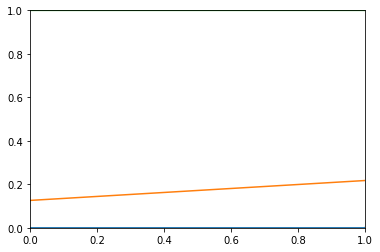

In [554]:
plt.plot(roc_curve(y_test,guessed))
plt.xlim(0,1.0);plt.ylim(0,1.0)

In [530]:
answers = sum_labels.iloc[y_test.index][['song title','artist name','rating']]

In [508]:
guessed.sum()

22

In [536]:
guessed = pd.DataFrame(model.predict_proba(x_test))

In [537]:
guessed[1].sort_values().index

Int64Index([145,   2,  72, 109,  22,  50, 135, 133,  10, 139,
            ...
             54,  28,  64,   5,  56, 122,  30,  17, 103, 137],
           dtype='int64', length=158)

In [544]:
pd.concat([guessed[1],answers.reset_index(drop=True)],1).sort_values(['rating',1],ascending=False)

,1,song title,artist name,rating
137,0.993331,Don't Want a Drive,EXID,1
17,0.934194,A Sul Hae,EXID,1
56,0.876379,Too Good to Me,EXID,1
5,0.861272,TROUBLE,EXID,1
54,0.728359,Better together,EXID,1
129,0.444015,Cream,EXID,1
123,0.441523,Without U - JPN ver.,EXID,1
32,0.423570,Like the Seasons,EXID,1
77,0.418301,Cookie & Cream,EXID,1
0,0.385792,Night Rather Than Day,EXID,1


I listen to some of the false positives, and I realize I don't need to be so down. "Lead me" by SISTAR could pass for one of EXID's downtempo songs, and the model identified it as 97% similar. The same goes for some of these Apink songs, like "What Are You Doing?"

As for the false negatives, I have to admit some of these songs divert from the group's usual style. "Now Hips," for example, could fit in with Girl's Day. Interestingly, "3%" by Solji and "Hot Pink" are, according to this model, not characteristic of EXID. I'd say this model works! Now to build a similar one for Mamamoo and Red Velvet. 